# Predicting Sentiments from the IMDB Dataset

In [ ]:
import pandas as pd
import numpy as np
from numpy.random import seed
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve,auc
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from wordcloud import WordCloud,STOPWORDS
import re,string,unicodedata
from bs4 import BeautifulSoup
from textblob import TextBlob
from textblob import Word
import spacy

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import Sequential
from keras.layers import Embedding,LSTM,Dense

import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

In [ ]:
seed(1)

In [ ]:
import os
import warnings
#print(os.listdir("../input"))
#warnings.filterwarnings('ignore')

## Due to the Large size of the dataset, The Data has been uploaded and can be downloaded via this google drive link: 

https://drive.google.com/file/d/1qIuWFYKpT3X37bBfep5wR63EWKUvCmpD/view?usp=sharing 

**Thank You.**

# Importing the dataset via Google Drive

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#imdb_data = pd.read_csv('/content/drive/MyDrive/ML Project/IMDB Dataset.csv')

## Import via Local Machine

In [ ]:
# imdb_data = pd.read_csv('C:/Users/tommy/Downloads/using imdb reviews csv/IMDB Dataset.csv')

## Overview

In [ ]:
print(imdb_data.shape)
imdb_data.head(10)

(50000, 2)


review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
5  Probably my all-time favorite movie, a story o...  positive
6  I sure would like to see a resurrection of a u...  positive
7  This show was an amazing, fresh & innovative i...  negative
8  Encouraged by the positive comments about this...  negative
9  If you like original gut wrenching laughter yo...  positive

In [ ]:
#Summary of the dataset
print("General stats:")
print(imdb_data.info())
print("\n")
print("Summary stats:")
print(imdb_data.describe())

General stats:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None


Summary stats:
                                                   review sentiment
count                                               50000     50000
unique                                              49582         2
top     Loved today's show!!! It was a variety and not...  positive
freq                                                    5     25000


## Sentiment count

In [ ]:
imdb_data['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

## Splitting the dataset

In [ ]:
 #train dataset
train_reviews=imdb_data.review[:40000]
train_sentiments=imdb_data.sentiment[:40000]

#test dataset
test_reviews=imdb_data.review[40000:]
test_sentiments=imdb_data.sentiment[40000:]
print(train_reviews.shape,train_sentiments.shape)
print(test_reviews.shape,test_sentiments.shape)

(40000,) (40000,)
(10000,) (10000,)


In [ ]:
# Viewing a review the dataset
train_reviews[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

**In the review output, There are stopwords,html tags,special charcters & numbers, which are not required for sentiment analysis. We need to remove those by normalizing the review data to reduce dimensionality & noise in the data.**

# Data Pre-Processing

## Text Normalization

In [ ]:
# Downloading the resource from nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#Tokenization of text
tokenizer = ToktokTokenizer()
#Setting English stopwords
stopword_list = nltk.corpus.stopwords.words('english')

## Removing html strips and noise text 

In [ ]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(denoise_text)

## Removing special characters

In [ ]:
#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(remove_special_characters)

## Text stemming

In [ ]:
#Stemming the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(simple_stemmer)

## Removing stopwords

In [ ]:
#set stopwords to english
stop = set(stopwords.words('english'))
print(stop)

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(remove_stopwords)

{'through', 'any', 'after', 'doesn', 'she', 'where', 'yourself', 'then', 'more', 'are', 'being', "you'd", 'yourselves', 'yours', 'few', 's', "wouldn't", 'a', 'its', 'me', 'was', 'or', 'once', 'there', 'had', 'did', 'during', 'on', 'does', 'for', 'hadn', 'the', 'own', "you're", 'why', 'can', 'nor', 'isn', "you'll", 'if', 'have', "you've", 'no', "don't", 'having', 'wasn', 'weren', 'your', "haven't", "hasn't", 'do', "mightn't", 'same', 'll', 'hasn', 'down', 'haven', 'with', 'won', 'those', 'over', 'he', 'itself', 'from', "doesn't", 'will', 'as', 'it', 'we', 'below', "mustn't", 'been', 'd', 'by', 'them', 'don', 'o', 'each', 'both', 'into', 'out', 'how', 'between', 'ma', 'you', 'again', 'off', 'until', 'needn', 'i', 'ours', "needn't", 'should', 'wouldn', 'and', "shouldn't", 'than', 'didn', 'but', 'whom', 'here', 'not', 'at', 'against', 'our', "should've", 've', 'herself', 'only', 'all', 'that', "that'll", 'now', 'shouldn', 'their', 'above', 'they', 'very', 'further', 'doing', 'theirs', "it'

## Normalized train reviews

In [ ]:
#normalized train reviews
norm_train_reviews=imdb_data.review[:40000]
norm_train_reviews[0]


'one review ha mention watch 1 Oz episod youll hook right thi exactli happen meth first thing struck Oz wa brutal unflinch scene violenc set right word GO trust thi show faint heart timid thi show pull punch regard drug sex violenc hardcor classic use wordit call OZ nicknam given oswald maximum secur state penitentari focus mainli emerald citi experiment section prison cell glass front face inward privaci high agenda Em citi home manyaryan muslim gangsta latino christian italian irish moreso scuffl death stare dodgi deal shadi agreement never far awayi would say main appeal show due fact goe show wouldnt dare forget pretti pictur paint mainstream audienc forget charm forget romanceoz doesnt mess around first episod ever saw struck nasti wa surreal couldnt say wa readi watch develop tast Oz got accustom high level graphic violenc violenc injustic crook guard wholl sold nickel inmat wholl kill order get away well manner middl class inmat turn prison bitch due lack street skill prison exp

### Using Text Blob for tokenization and Spelling correction Train

In [ ]:
#convert dataframe to string
#norm_train_string=norm_train_reviews.to_string()
#Spelling correction using Textblob
#norm_train_spelling=TextBlob(norm_train_string)
#norm_train_spelling.correct()
#Tokenization using Textblob
#norm_train_words=norm_train_spelling.words
#norm_train_words

## Normalized test reviews

In [ ]:
#Normalized test reviews
norm_test_reviews=imdb_data.review[40000:]
norm_test_reviews[45005]


'read review watch thi piec cinemat garbag took least 2 page find somebodi els didnt think thi appallingli unfunni montag wasnt acm humour 70 inde ani era thi isnt least funni set sketch comedi ive ever seen itll till come along half skit alreadi done infinit better act monti python woodi allen wa say nice piec anim last 90 second highlight thi film would still get close sum mindless drivelridden thi wast 75 minut semin comedi onli world semin realli doe mean semen scatolog humour onli world scat actual fece precursor joke onli mean thi handbook comedi tit bum odd beaver niceif pubesc boy least one hand free havent found playboy exist give break becaus wa earli 70 way sketch comedi go back least ten year prior onli way could even forgiv thi film even made wa gunpoint retro hardli sketch clown subtli pervert children may cut edg circl could actual funni come realli quit sad kept go throughout entir 75 minut sheer belief may save genuin funni skit end gave film 1 becaus wa lower scoreand

### Using Text Blob for tokenization and Spelling correction Test

In [ ]:
##convert dataframe to string
#norm_test_string=norm_test_reviews.to_string()
#spelling correction using Textblob
#norm_test_spelling=TextBlob(norm_test_string)
#print(norm_test_spelling.correct())
#Tokenization using Textblob
#norm_test_words=norm_test_spelling.words
#norm_test_words

## Bags of words model
**It is used to convert text documents to numerical vectors or bag of words**

In [ ]:
#Count vectorizer for bag of words
cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
#transformed train reviews
cv_train_reviews=cv.fit_transform(norm_train_reviews)
#transformed test reviews
cv_test_reviews=cv.transform(norm_test_reviews)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)
#vocab=cv.get_feature_names()-toget feature names

BOW_cv_train: (40000, 6209089)
BOW_cv_test: (10000, 6209089)


## Term Frequency-Inverse Document Frequency model (TFIDF)

In [ ]:
#Tfidf vectorizer
tv = TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))
#transformed train reviews
tv_train_reviews = tv.fit_transform(norm_train_reviews)
#transformed test reviews
tv_test_reviews = tv.transform(norm_test_reviews)
print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

Tfidf_train: (40000, 6209089)
Tfidf_test: (10000, 6209089)


## Labeling the sentiment text 

In [ ]:
#labeling the sentient data
lb = LabelBinarizer()
#transformed sentiment data
sentiment_data = lb.fit_transform(imdb_data['sentiment'])
print(sentiment_data.shape)

(50000, 1)


## Split the sentiment data

In [ ]:
#Spliting the sentiment data
train_sentiments = sentiment_data[:40000]
test_sentiments = sentiment_data[40000:]
print(train_sentiments)
print(test_sentiments)

[[1]
 [1]
 [1]
 ...
 [1]
 [0]
 [0]]
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


# Models

## logistic regression model for both bag of words and tfidf features

In [ ]:
#training the model
lr = LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)
#Fitting the model for Bag of words
lr_bow = lr.fit(cv_train_reviews,train_sentiments)
print(lr_bow)
#Fitting the model for tfidf features
lr_tfidf = lr.fit(tv_train_reviews,train_sentiments)
print(lr_tfidf)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


## Logistic regression model performance on test dataset

In [ ]:
#Predicting the model for bag of words
lr_bow_predict=lr.predict(cv_test_reviews)
print(lr_bow_predict)
##Predicting the model for tfidf features
lr_tfidf_predict=lr.predict(tv_test_reviews)
print(lr_tfidf_predict)

[0 0 0 ... 0 1 1]
[0 0 0 ... 0 1 1]


## Accuracy of the model

In [ ]:
#Accuracy score for bag of words
lr_bow_score=accuracy_score(test_sentiments,lr_bow_predict)
print("lr_bow_score :",lr_bow_score)
#Accuracy score for tfidf features
lr_tfidf_score=accuracy_score(test_sentiments,lr_tfidf_predict)
print("lr_tfidf_score :",lr_tfidf_score)

lr_bow_score : 0.7512
lr_tfidf_score : 0.75


## Print the classification report

In [ ]:
#Classification report for bag of words 
lr_bow_report=classification_report(test_sentiments,lr_bow_predict,target_names=['Positive','Negative'])
print(lr_bow_report)

#Classification report for tfidf features
lr_tfidf_report=classification_report(test_sentiments,lr_tfidf_predict,target_names=['Positive','Negative'])
print(lr_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.75      0.75      0.75      4993
    Negative       0.75      0.75      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000

              precision    recall  f1-score   support

    Positive       0.74      0.77      0.75      4993
    Negative       0.76      0.73      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



## Confusion matrix

In [ ]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,lr_bow_predict,labels=[1,0])
print(cm_bow)
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,lr_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[3768 1239]
 [1249 3744]]
[[3663 1344]
 [1156 3837]]


In [ ]:
# Put a better Confusion Matrix

## Stochastic gradient descent or Linear support vector machines for bag of words and tfidf features

In [ ]:
#training the linear svm
svm=SGDClassifier(loss='hinge',max_iter=500,random_state=42)
#fitting the svm for bag of words
svm_bow=svm.fit(cv_train_reviews,train_sentiments)
print(svm_bow)
#fitting the svm for tfidf features
svm_tfidf=svm.fit(tv_train_reviews,train_sentiments)
print(svm_tfidf)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=500, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=500, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)


## Model performance on test data

In [ ]:
#Predicting the model for bag of words
svm_bow_predict=svm.predict(cv_test_reviews)
print(svm_bow_predict)
#Predicting the model for tfidf features
svm_tfidf_predict=svm.predict(tv_test_reviews)
print(svm_tfidf_predict)

[1 1 0 ... 1 1 1]
[1 1 1 ... 1 1 1]


## Accuracy of the model

In [ ]:
#Accuracy score for bag of words
svm_bow_score=accuracy_score(test_sentiments,svm_bow_predict)
print("svm_bow_score :",svm_bow_score)
#Accuracy score for tfidf features
svm_tfidf_score=accuracy_score(test_sentiments,svm_tfidf_predict)
print("svm_tfidf_score :",svm_tfidf_score)

svm_bow_score : 0.5829
svm_tfidf_score : 0.5112


## Print the classification report

In [ ]:
#Classification report for bag of words 
svm_bow_report=classification_report(test_sentiments,svm_bow_predict,target_names=['Positive','Negative'])
print(svm_bow_report)
#Classification report for tfidf features
svm_tfidf_report=classification_report(test_sentiments,svm_tfidf_predict,target_names=['Positive','Negative'])
print(svm_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.94      0.18      0.30      4993
    Negative       0.55      0.99      0.70      5007

    accuracy                           0.58     10000
   macro avg       0.74      0.58      0.50     10000
weighted avg       0.74      0.58      0.50     10000

              precision    recall  f1-score   support

    Positive       1.00      0.02      0.04      4993
    Negative       0.51      1.00      0.67      5007

    accuracy                           0.51     10000
   macro avg       0.75      0.51      0.36     10000
weighted avg       0.75      0.51      0.36     10000



## Plot the confusion matrix

In [ ]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,svm_bow_predict,labels=[1,0])
print(cm_bow)
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,svm_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[4948   59]
 [4112  881]]
[[5007    0]
 [4888  105]]


## Multinomial Naive Bayes for bag of words and tfidf features

In [ ]:
#training the model
mnb=MultinomialNB()
#fitting the svm for bag of words
mnb_bow=mnb.fit(cv_train_reviews,train_sentiments)
print(mnb_bow)
#fitting the svm for tfidf features
mnb_tfidf=mnb.fit(tv_train_reviews,train_sentiments)
print(mnb_tfidf)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)


## Model performance on test data

In [ ]:
#Predicting the model for bag of words
mnb_bow_predict=mnb.predict(cv_test_reviews)
print(mnb_bow_predict)
#Predicting the model for tfidf features
mnb_tfidf_predict=mnb.predict(tv_test_reviews)
print(mnb_tfidf_predict)

[0 0 0 ... 0 1 1]
[0 0 0 ... 0 1 1]


## Accuracy of the model

In [ ]:
#Accuracy score for bag of words
mnb_bow_score=accuracy_score(test_sentiments,mnb_bow_predict)
print("mnb_bow_score :",mnb_bow_score)
#Accuracy score for tfidf features
mnb_tfidf_score=accuracy_score(test_sentiments,mnb_tfidf_predict)
print("mnb_tfidf_score :",mnb_tfidf_score)

mnb_bow_score : 0.751
mnb_tfidf_score : 0.7509


## Print the classification report

In [ ]:
#Classification report for bag of words 
mnb_bow_report=classification_report(test_sentiments,mnb_bow_predict,target_names=['Positive','Negative'])
print(mnb_bow_report)
#Classification report for tfidf features
mnb_tfidf_report=classification_report(test_sentiments,mnb_tfidf_predict,target_names=['Positive','Negative'])
print(mnb_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.75      0.76      0.75      4993
    Negative       0.75      0.75      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000

              precision    recall  f1-score   support

    Positive       0.75      0.76      0.75      4993
    Negative       0.75      0.74      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



## Plot the confusion matrix

In [ ]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,mnb_bow_predict,labels=[1,0])
print(cm_bow)
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,mnb_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[3736 1271]
 [1219 3774]]
[[3729 1278]
 [1213 3780]]


# Visualization
## Word cloud for positive review words

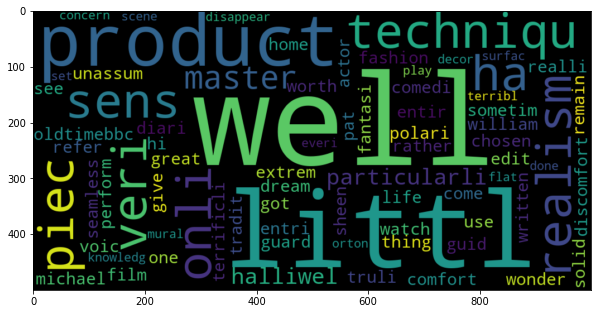

In [ ]:
#word cloud for positive review words
plt.figure(figsize=(10,10))
positive_text=norm_train_reviews[1]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show()

## Word cloud for negative review words

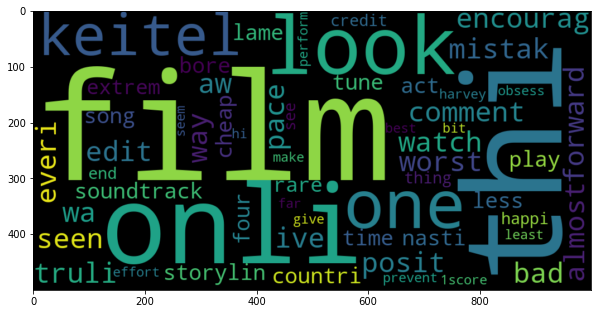

In [ ]:
#Word cloud for negative review words
plt.figure(figsize=(10,10))
negative_text=norm_train_reviews[8]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show()

## Conclusion:
* We can observed that both logistic regression and multinomial naive bayes model performing well compared to linear support vector  machines

*** 

### Using Text Blob for tokenization and Spelling correction Train

In [ ]:
#convert dataframe to string
#norm_train_string=norm_train_reviews.to_string()
#Spelling correction using Textblob
#norm_train_spelling=TextBlob(norm_train_string)
#norm_train_spelling.correct()
#Tokenization using Textblob
#norm_train_words=norm_train_spelling.words
#norm_train_words

### Using Text Blob for tokenization and Spelling correction Test

In [ ]:
##convert dataframe to string
#norm_test_string=norm_test_reviews.to_string()
#spelling correction using Textblob
#norm_test_spelling=TextBlob(norm_test_string)
#print(norm_test_spelling.correct())
#Tokenization using Textblob
#norm_test_words=norm_test_spelling.words
#norm_test_words

# Models 2
## Radom Forest and Deep Learning Model


In [ ]:
reviews=imdb_data['review']
sentiment=imdb_data['sentiment']

Split into train and test and encode target

In [ ]:
train_reviews=reviews[:30000]
train_sentiment=sentiment[:30000]
test_reviews=reviews[30000:]
test_sentiment=sentiment[30000:]
#Shape of train & test dataset
print('Shape of train dataset::',train_reviews.shape,train_sentiment.shape)
print('Shape of test dataset::',test_reviews.shape,test_sentiment.shape)

Shape of train dataset:: (30000,) (30000,)
Shape of test dataset:: (20000,) (20000,)


In [ ]:
lb=preprocessing.LabelBinarizer()
#Encode 1 for positive label & 0 for Negative label
train_sentiment=lb.fit_transform(train_sentiment)
test_sentiment=lb.transform(test_sentiment)
#Reshape the array
train_sentiment=train_sentiment.ravel()  
test_sentiment=test_sentiment.ravel()
#Convert categoricals to numeric ones
train_sentiment=train_sentiment.astype('int64')
test_sentiment=test_sentiment.astype('int64')

In [ ]:
train_reviews[0]

'one review ha mention watch 1 Oz episod youll hook right thi exactli happen meth first thing struck Oz wa brutal unflinch scene violenc set right word GO trust thi show faint heart timid thi show pull punch regard drug sex violenc hardcor classic use wordit call OZ nicknam given oswald maximum secur state penitentari focus mainli emerald citi experiment section prison cell glass front face inward privaci high agenda Em citi home manyaryan muslim gangsta latino christian italian irish moreso scuffl death stare dodgi deal shadi agreement never far awayi would say main appeal show due fact goe show wouldnt dare forget pretti pictur paint mainstream audienc forget charm forget romanceoz doesnt mess around first episod ever saw struck nasti wa surreal couldnt say wa readi watch develop tast Oz got accustom high level graphic violenc violenc injustic crook guard wholl sold nickel inmat wholl kill order get away well manner middl class inmat turn prison bitch due lack street skill prison exp

In [ ]:
test_reviews[30001]

'thi one silliest movi ever misfortun watch expect see first two keep get sucker type movi idea mayb right thi time nope even closewher begin special effect give idea pass sfx thi movi one point soldier shoot raptor run hallway even less second screen time viewer easili see man tail appar tape run around bad bad bad badhow act call one charact suppos suppos south howev live south six year never heard thi way talk perhap ha sort weird disabl inabl talk normal find fascin charact doe noth requir accent therefor wa reason actor tri onehow plot pretti basic raptor escap peopl gun must hunt Im start wonder whi dinosaur movi alway seem run nearest system tunnel wouldnt stay outsid hunt prey Oh well least good sens appear veri veri littl movi supposedli revolv around themoth thing let say build know man eat raptor run around would decid take time argument better armi marin decid arm wrestl contest settl idiot idea track raptor split group two didnt ever watch ani horror movi least episod scoo

## Normalization - train and test

In [ ]:
ps=PorterStemmer()
stopwords= set(stopwords.words('english'))

# Define function for data mining
def normalize_reviews(review):
    #Excluding html tags
    data_tags=re.sub(r'<[^<>]+>'," ",review)
    #Remove special characters/whitespaces
    data_special=re.sub(r'[^a-zA-Z0-9\s]','',data_tags)
    #converting to lower case
    data_lowercase=data_special.lower()
    #tokenize review data
    data_split=data_lowercase.split()
    #Removing stop words
    meaningful_words=[w for w in data_split if not w in stopwords]
    #Appply stemming
    text= ' '.join([ps.stem(word) for word in meaningful_words])
    return text

In [ ]:
norm_train_reviews=train_reviews.apply(normalize_reviews)
norm_test_reviews=test_reviews.apply(normalize_reviews)

In [ ]:
norm_train_reviews[0]
norm_test_reviews[30001]

'thi one silliest movi ever misfortun watch expect see first two keep get sucker type movi idea mayb right thi time nope even closewh begin special effect give idea pass sfx thi movi one point soldier shoot raptor run hallway even less second screen time viewer easili see man tail appar tape run around bad bad bad badhow act call one charact suppo suppo south howev live south six year never heard thi way talk perhap ha sort weird disabl inabl talk normal find fascin charact doe noth requir accent therefor wa reason actor tri onehow plot pretti basic raptor escap peopl gun must hunt im start wonder whi dinosaur movi alway seem run nearest system tunnel wouldnt stay outsid hunt prey oh well least good sen appear veri veri littl movi supposedli revolv around themoth thing let say build know man eat raptor run around would decid take time argument better armi marin decid arm wrestl contest settl idiot idea track raptor split group two didnt ever watch ani horror movi least episod scoobi do

## Create Features using bag of words model

In [ ]:
cv = CountVectorizer(ngram_range=(1,2))
train_cv = cv.fit_transform(norm_train_reviews)
test_cv = cv.transform(norm_test_reviews)
print('Shape of train_cv::',train_cv.shape)
print('Shape of test_cv::',test_cv.shape)

Shape of train_cv:: (30000, 1985124)
Shape of test_cv:: (20000, 1985124)


## Create Features using Term Frequency-Inverse Document Frequency model

In [ ]:
#Tfidf vectorizer
tv = TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))
#transformed train reviews
train_tv = tv.fit_transform(norm_train_reviews)
#transformed test reviews
test_tv = tv.transform(norm_test_reviews)
print('Tfidf_train:',train_tv.shape)
print('Tfidf_test:',test_tv.shape)

Tfidf_train: (30000, 4822317)
Tfidf_test: (20000, 4822317)


## Random Forest Model - Bag of Words

In [ ]:
%%time
#Training the classifier
rfc=RandomForestClassifier(n_estimators=20,random_state=42)
rfc=rfc.fit(train_cv,train_sentiment)
score=rfc.score(train_cv,train_sentiment)
print('Accuracy of trained model is ::',score)

Accuracy of trained model is :: 0.9995
CPU times: user 3min 13s, sys: 140 ms, total: 3min 13s
Wall time: 3min 12s


In [ ]:
%%time
#Making predicitions
rfc_predict=rfc.predict(test_cv)

CPU times: user 1.93 s, sys: 5 ms, total: 1.94 s
Wall time: 1.92 s


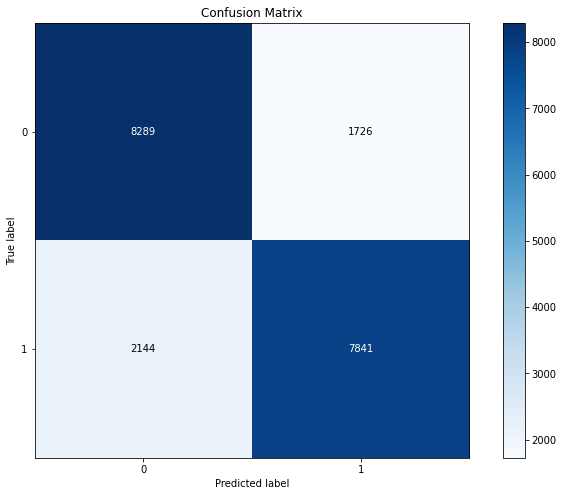

In [ ]:
# Model Accuracy
cm=confusion_matrix(test_sentiment,rfc_predict)

# plot our confusion matrix
skplt.metrics.plot_confusion_matrix(test_sentiment,rfc_predict,normalize=False,figsize=(12,8))
plt.show()

In [ ]:
# print classification report for performance metrics
cr=classification_report(test_sentiment,rfc_predict)
print('Classification report is::\n',cr)

Classification report is::
               precision    recall  f1-score   support

           0       0.79      0.83      0.81     10015
           1       0.82      0.79      0.80      9985

    accuracy                           0.81     20000
   macro avg       0.81      0.81      0.81     20000
weighted avg       0.81      0.81      0.81     20000



In [ ]:
# ROC curve for Random Forest Classifier
fpr_rf,tpr_rf,threshold_rf=roc_curve(test_sentiment,rfc_predict)
#Area under curve (AUC) score, fpr-False Positive rate, tpr-True Positive rate
auc_rf=auc(fpr_rf,tpr_rf)
print('AUC score for Random Forest classifier::',np.round(auc_rf,3))

AUC score for Random Forest classifier:: 0.806


## Random Forest Model - TFIDF

In [ ]:
%%time
#Training the classifier
rfc = RandomForestClassifier(n_estimators=20,random_state=20)
rfc = rfc.fit(train_tv,train_sentiment)
score = rfc.score(train_tv,train_sentiment)
print('Accuracy of trained model is ::',score)

Accuracy of trained model is :: 0.9962333333333333
CPU times: user 37min 7s, sys: 2.37 s, total: 37min 9s
Wall time: 36min 52s


In [ ]:
%%time
#Making predicitions
rfc_predict = rfc.predict(test_tv)

CPU times: user 1min, sys: 59.6 ms, total: 1min
Wall time: 59.9 s


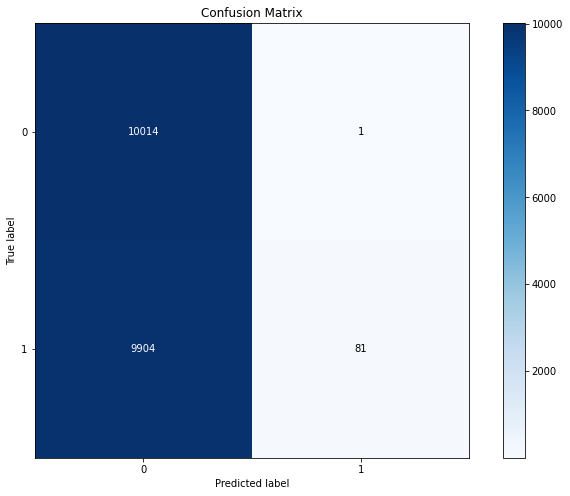

In [ ]:
# Model Accuracy
cm = confusion_matrix(test_sentiment,rfc_predict)

# plot our confusion matrix
skplt.metrics.plot_confusion_matrix(test_sentiment,rfc_predict,normalize=False,figsize=(12,8))
plt.show()

In [ ]:
# print classification report for performance metrics
cr = classification_report(test_sentiment,rfc_predict)
print('Classification report is::\n',cr)

Classification report is::
               precision    recall  f1-score   support

           0       0.50      1.00      0.67     10015
           1       0.99      0.01      0.02      9985

    accuracy                           0.50     20000
   macro avg       0.75      0.50      0.34     20000
weighted avg       0.74      0.50      0.34     20000



In [ ]:
# ROC curve for Random Forest Classifier
fpr_rf,tpr_rf,threshold_rf = roc_curve(test_sentiment,rfc_predict)
#Area under curve (AUC) score, fpr-False Positive rate, tpr-True Positive rate
auc_rf = auc(fpr_rf,tpr_rf)
print('AUC score for Random Forest classifier::',np.round(auc_rf,3))

AUC score for Random Forest classifier:: 0.504


## Deep Learning Model - Bag of Words
**Recurrent neural network (RNN) with LSTM (Long Short Term Memory) model**

In [ ]:
#Train dataset
X_train=train_cv
X_train=[str(x[0]) for x in X_train]
y_train=train_sentiment
# Test dataset
X_test=test_cv
X_test=[str(x[0]) for x in X_test]
y_test=test_sentiment

In [ ]:
# Tokenize the train & test dataset
Max_Review_length=500
tokenizer=Tokenizer(num_words=Max_Review_length,lower=False)
tokenizer.fit_on_texts(X_train)
#tokenizig train data
X_train_token=tokenizer.texts_to_sequences(X_train)
#tokenizing test data
X_test_token=tokenizer.texts_to_sequences(X_test)

#Truncate or pad the dataset for a length of 500 words for each review
X_train=pad_sequences(X_train_token,maxlen=Max_Review_length)
X_test=pad_sequences(X_test_token,maxlen=Max_Review_length)

In [ ]:
print('Shape of X_train datset after padding:',X_train.shape)
print('Shape of X_test dataset after padding:',X_test.shape)

Shape of X_train datset after padding: (30000, 500)
Shape of X_test dataset after padding: (20000, 500)


In [ ]:
%%time
# Most poplar words found in the dataset
vocabulary_size=5000 
embedding_size=64
model=Sequential()
model.add(Embedding(vocabulary_size,embedding_size,input_length=Max_Review_length))
model.add(LSTM(30))
model.add(Dense(1,activation='sigmoid',kernel_initializer='random_uniform'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 64)           320000    
_________________________________________________________________
lstm (LSTM)                  (None, 30)                11400     
_________________________________________________________________
dense (Dense)                (None, 1)                 31        
Total params: 331,431
Trainable params: 331,431
Non-trainable params: 0
_________________________________________________________________
CPU times: user 508 ms, sys: 45 ms, total: 553 ms
Wall time: 905 ms


In [ ]:
#Complile our model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
%%time
#Train our model
batch_size=128
num_epochs=6
X_valid,y_valid=X_train[:batch_size],train_sentiment[:batch_size]
X_train1,y_train1=X_train[batch_size:],train_sentiment[batch_size:]
# Fit the model
model.fit(X_train1,y_train1,validation_data=(X_valid,y_valid),validation_split=0.2,
          batch_size=batch_size,epochs=num_epochs, verbose=1,shuffle=True)

Epoch 1/6
187/187 [==============================] - 95s 390ms/step - loss: 0.6732 - accuracy: 0.5548 - val_loss: 0.5319 - val_accuracy: 0.7381
Epoch 2/6
187/187 [==============================] - 71s 382ms/step - loss: 0.5020 - accuracy: 0.7638 - val_loss: 0.4940 - val_accuracy: 0.7657
Epoch 3/6
187/187 [==============================] - 72s 387ms/step - loss: 0.4899 - accuracy: 0.7678 - val_loss: 0.5071 - val_accuracy: 0.7635
Epoch 4/6
187/187 [==============================] - 71s 380ms/step - loss: 0.4620 - accuracy: 0.7815 - val_loss: 0.4825 - val_accuracy: 0.7714
Epoch 5/6
187/187 [==============================] - 71s 381ms/step - loss: 0.4554 - accuracy: 0.7907 - val_loss: 0.4745 - val_accuracy: 0.7799
Epoch 6/6
187/187 [==============================] - 75s 403ms/step - loss: 0.4456 - accuracy: 0.7916 - val_loss: 0.4808 - val_accuracy: 0.7682
CPU times: user 12min 49s, sys: 28.9 s, total: 13min 18s
Wall time: 7min 43s


In [ ]:
%%time
# Predictions
y_predict_rnn=model.predict(X_test)
#Changing the shape of y_predict to 1-Dimensional
y_predict_rnn1=y_predict_rnn.ravel()
y_predict_rnn1=(y_predict_rnn1>0.5)
y_predict_rnn1[0:10]

CPU times: user 42 s, sys: 605 ms, total: 42.7 s
Wall time: 23.4 s


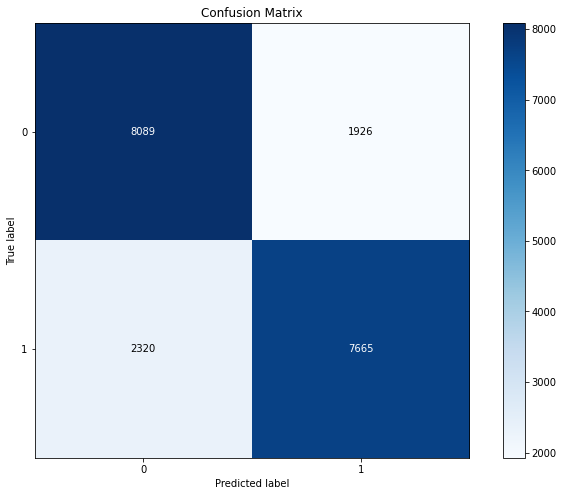

In [ ]:
#Confusion matrix for RNN with LSTM
cm_rnn=confusion_matrix(y_test,y_predict_rnn1)
#plot our confusion matrix
skplt.metrics.plot_confusion_matrix(y_test,y_predict_rnn1,normalize=False,figsize=(12,8))
plt.show()

In [ ]:
#Classification report for performance metrics
cr_rnn=classification_report(y_test,y_predict_rnn1)
print('The Classification report is::\n',cr_rnn)

The Classification report is::
               precision    recall  f1-score   support

           0       0.78      0.81      0.79     10015
           1       0.80      0.77      0.78      9985

    accuracy                           0.79     20000
   macro avg       0.79      0.79      0.79     20000
weighted avg       0.79      0.79      0.79     20000



In [ ]:
#ROC curve for RNN with LSTM
fpr_rnn,tpr_rnn,thresold_rnn=roc_curve(y_test,y_predict_rnn)
#AUC score for RNN
auc_rnn=auc(fpr_rnn,tpr_rnn)
print('AUC score for RNN with LSTM ::',np.round(auc_rnn,3))

AUC score for RNN with LSTM :: 0.873


## Deep Learning Model - TFIDF

In [ ]:
#Train dataset
X_train = train_tv
X_train = [str(x[0]) for x in X_train]
y_train = train_sentiment
# Test dataset
X_test = test_tv
X_test = [str(x[0]) for x in X_test]
y_test = test_sentiment

In [ ]:
# Tokenize the train & test dataset
Max_Review_length=500
tokenizer = Tokenizer(num_words=Max_Review_length,lower=False)
tokenizer.fit_on_texts(X_train)
#tokenizig train data
X_train_token = tokenizer.texts_to_sequences(X_train)
#tokenizing test data
X_test_token = tokenizer.texts_to_sequences(X_test)

#Truncate or pad the dataset for a length of 500 words for each review
X_train = pad_sequences(X_train_token,maxlen=Max_Review_length)
X_test=pad_sequences(X_test_token,maxlen=Max_Review_length)

In [ ]:
print('Shape of X_train datset after padding:',X_train.shape)
print('Shape of X_test dataset after padding:',X_test.shape)

Shape of X_train datset after padding: (30000, 500)
Shape of X_test dataset after padding: (20000, 500)


In [ ]:
%%time
# Most popular words found in the dataset
vocabulary_size=5000 
embedding_size=64
model=Sequential()
model.add(Embedding(vocabulary_size,embedding_size,input_length=Max_Review_length))
model.add(LSTM(30))
model.add(Dense(1,activation='sigmoid',kernel_initializer='random_uniform'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 64)           320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 30)                11400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 331,431
Trainable params: 331,431
Non-trainable params: 0
_________________________________________________________________
CPU times: user 309 ms, sys: 3.97 ms, total: 313 ms
Wall time: 313 ms


In [ ]:
#Complile our model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
%%time
#Train our model
batch_size = 128
num_epochs = 6
X_valid,y_valid = X_train[:batch_size],train_sentiment[:batch_size]
X_train1,y_train1 = X_train[batch_size:],train_sentiment[batch_size:]
# Fit the model
model.fit(X_train1,y_train1,validation_data=(X_valid,y_valid),validation_split=0.2,
          batch_size=batch_size,epochs=num_epochs, verbose=1,shuffle=True)

Epoch 1/6
187/187 [==============================] - 74s 380ms/step - loss: 0.6931 - accuracy: 0.4965 - val_loss: 0.6917 - val_accuracy: 0.5073
Epoch 2/6
187/187 [==============================] - 71s 379ms/step - loss: 0.6899 - accuracy: 0.5368 - val_loss: 0.6930 - val_accuracy: 0.5091
Epoch 3/6
187/187 [==============================] - 71s 382ms/step - loss: 0.6861 - accuracy: 0.5457 - val_loss: 0.6957 - val_accuracy: 0.5059
Epoch 4/6
187/187 [==============================] - 71s 381ms/step - loss: 0.6842 - accuracy: 0.5522 - val_loss: 0.6974 - val_accuracy: 0.5033
Epoch 5/6
187/187 [==============================] - 73s 391ms/step - loss: 0.6831 - accuracy: 0.5487 - val_loss: 0.7000 - val_accuracy: 0.5058
Epoch 6/6
187/187 [==============================] - 73s 388ms/step - loss: 0.6842 - accuracy: 0.5488 - val_loss: 0.7003 - val_accuracy: 0.5069
CPU times: user 12min 29s, sys: 26.5 s, total: 12min 56s
Wall time: 7min 24s


In [ ]:
%%time
# Predictions
y_predict_rnn = model.predict(X_test)
#Changing the shape of y_predict to 1-Dimensional
y_predict_rnn1 = y_predict_rnn.ravel()
y_predict_rnn1 = (y_predict_rnn1>0.5)
y_predict_rnn1[0:10]

CPU times: user 44.3 s, sys: 633 ms, total: 44.9 s
Wall time: 24.7 s


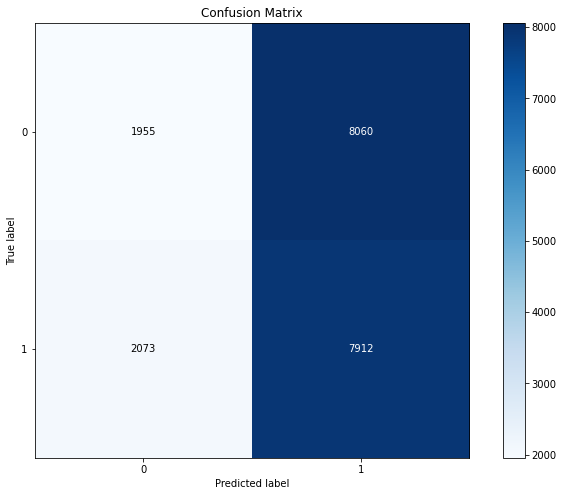

In [ ]:
#Confusion matrix for RNN with LSTM
cm_rnn = confusion_matrix(y_test,y_predict_rnn1)
#plot our confusion matrix
skplt.metrics.plot_confusion_matrix(y_test,y_predict_rnn1,normalize=False,figsize=(12,8))
plt.show()

In [ ]:
# Classification report for performance metrics
cr_rnn = classification_report(y_test,y_predict_rnn1)
print('The Classification report is::\n',cr_rnn)

The Classification report is::
               precision    recall  f1-score   support

           0       0.49      0.20      0.28     10015
           1       0.50      0.79      0.61      9985

    accuracy                           0.49     20000
   macro avg       0.49      0.49      0.44     20000
weighted avg       0.49      0.49      0.44     20000



In [ ]:
# ROC curve for RNN with LSTM
fpr_rnn,tpr_rnn,thresold_rnn=roc_curve(y_test,y_predict_rnn)
#AUC score for RNN
auc_rnn = auc(fpr_rnn,tpr_rnn)
print('AUC score for RNN with LSTM ::',np.round(auc_rnn,3))

AUC score for RNN with LSTM :: 0.493


***